In [ ]:
#import tensorflow_datasets as tfds
#import tensorflow as tf
#import numpy as np

#(train_ds, test_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#print(ds_info)
#tfds.show_examples(train_ds,ds_info)
#print(np.amax(train_ds))

'get range of pixels in image?'

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


'get range of pixels in image?'

In [ ]:
def prepare_mnist_dataset(mnist):
  # flatten images 
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  # cast img type to float
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  # normalize values
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  # onehot encoding
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth = 10)))
  # cache progress in memory
  mnist = mnist.cache()
  # shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)

  return mnist

#train_dataset = train_ds.apply(prepare_mnist_dataset)
#test_dataset = test_ds.apply(prepare_mnist_dataset)


AttributeError: ignored

In [48]:
def prepare_mnist_dataset_short(mnist):
  mnist = mnist.map(lambda img, target: ((tf.cast(tf.reshape(img, (-1,)), tf.float32)/128.)-1., tf.one_hot(target, depth=10))).cache().shuffle(1000).batch(32).prefetch(20)
  return mnist
train_dataset = train_ds.apply(prepare_mnist_dataset_short)
test_dataset = test_ds.apply(prepare_mnist_dataset_short)

In [61]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)

    self.out = tf.keras.layers.Dense(10, activation= tf.nn.sigmoid) #tf.nn.softmax)

  @tf.function
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.out(x)
    return x

In [57]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test_step(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis=1))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
num_epochs = 10
learning_rate = 0.05

# Initialize the model
model = MyModel()
cross_entropy_loss = tf.keras.losses.CategoricalHinge()#CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = 0.03)

# visualization lists
train_losses = []
test_losses = []
test_accuracies = []

# testing on test data before begin
test_loss, test_accuracy = test_step(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# testing on test data before begin
train_loss, _ = test_step(model, train_dataset, cross_entropy_loss)
train_losses.append(test_loss)

# train for epochs
for epoch in range(num_epochs):
  # why here test_accuracies[-1]
  print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')  

  epoch_loss_agg = []
  for input, target in train_dataset:
    train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    epoch_loss_agg.append(train_loss)

  train_losses.append(tf.reduce_mean(epoch_loss_agg))

  test_loss, test_accuracy = test_step(model, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


Epoch: 0 starting with accuracy 0.12450079872204473
Epoch: 1 starting with accuracy 0.9135383386581469
Epoch: 2 starting with accuracy 0.9409944089456869
Epoch: 3 starting with accuracy 0.9476837060702875
Epoch: 4 starting with accuracy 0.9583666134185304


final training loss: 0.059816308319568634  final test loss: 0.06589389592409134    final test accuracy: 0.9714456869009584


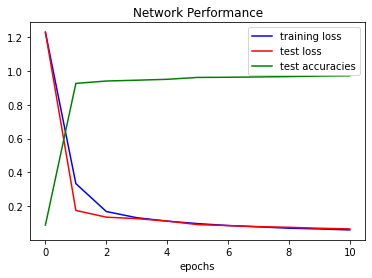

In [67]:
import matplotlib.pyplot as plt

def plot(train_losses, test_losses, test_accuracies):
  line1, = plt.plot(train_losses, 'b-', label='training loss')
  line2, = plt.plot(test_losses, 'r-', label='test loss')
  line3, = plt.plot(test_accuracies, 'g-', label='test accuracies')

  plt.title('Network Performance')
  plt.xlabel('epochs')
  plt.legend(handles=[line1,line2,line3])
  plt.show

plot(train_losses, test_losses, test_accuracies)
print(f'final training loss: {train_losses[-1]}  final test loss: {test_losses[-1]}    final test accuracy: {test_accuracies[-1]}')